# Least-Square Fitting

In this notebook, we'll examine some simple examples of *least-square fitting* to polynomials, also called *polynomial regression*.

## Review: Least-squares fits and the normal equations

As derived in any linear-algebra textbook, minimizing $\Vert b - Ax\Vert_2$ or (equivalently) $\Vert b - Ax\Vert_2^2$ leads to the so-called **"normal equations"** for the minimizer $\hat{x}$:

$$
\boxed{ A^* A \hat{x} = A^* b }
$$

These *always* have a solution.  If $A$ is an $m \times n$ matrix, then $A^* A$ is $n \times n$, and:

* Usually in fitting problems, $A$ is a "tall" matrix with full column rank $n$, in which case $\operatorname{rank}(A^* A) = \operatorname{rank}(A) = n$ and $A^* A$ is *invertible*: the solution $\hat{x}$ exists and is unique.

* Even if $\operatorname{rank}(A) < n$, we still have a (non-unique) solution, because $A^* b \in C(A^*) = N(A)^\perp = N(A^* A)^\perp = C(A^* A)$.

We can derive these equations in various ways.  However:
        
* In numerical linear algebra, we **rarely use the normal equations explicitly**.  That's because $\kappa(A^*A)=\kappa(A)^2$ — forming $A^*A$ **squares the condition number**.

Instead, we will use other algorithms, typically based on QR factorization.  For now, we will just use `A \ b` in Julia, which uses a "good" algorithm.

## Sample data and fit matrices

We'll start by creating some sample data: a hyperbola $y = \sqrt{x^2 + 1}$ plus some (gaussian) noise.

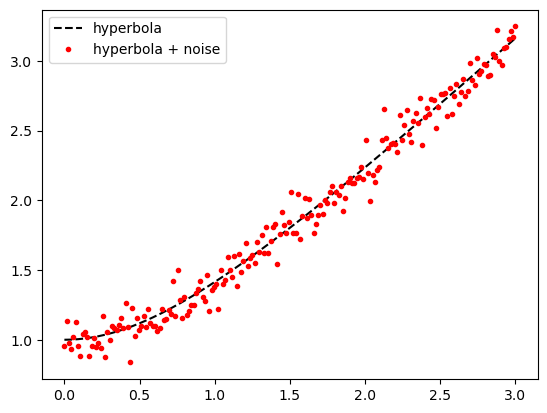

PyObject <matplotlib.legend.Legend object at 0x7fe28976ded0>

In [1]:
using PyPlot

x = range(0, 3, length=200)
y = @. sqrt(x^2 + 1)                # hyperbola
yn = @. y + randn()*0.1     #  + noise
plot(x, y, "k--")
plot(x, yn, "r.")
legend(["hyperbola", "hyperbola + noise"], loc="upper left")

Our least-square solution minimizes the error norm $\Vert Ac - b\Vert_2$ where $c$ are the coefficients of a polynomial fit $c[1] + c[2] x + c[3] x^2 + \cdots + c[n+1] x^n$, $b$ is the vector of data points $yn[i]$ that we are fitting to, and $A$ is the matrix whose columns are $x^0, x^1, \ldots$.

In particular, suppose we are fitting m points $(x_k,b_k)$ to a degree-(n+1) polynomial of the form

$$
p(x) = c_1 + c_2 x + c_3 x^2 + \cdots + c_n x^{n-1} \; ,
$$

which leads to the $m \times n$ matrix

$$
A = \begin{pmatrix}
        1 & x_1 & x_1^2 & \cdots x_1^{n-1} \\
        1 & x_2 & x_2^2 & \cdots x_2^{n-1} \\
        1 & x_3 & x_3^2 & \cdots x_3^{n-1} \\
        \vdots & \vdots & \vdots & \vdots \\
        1 & x_m & x_m^2 & \cdots x_m^{n-1} \\
    \end{pmatrix}
$$

There are several ways to construct such a "Vandermonde" matrix $A$ in Julia.  For example, for $n=2$:

In [2]:
A = [x.^0 x.^1 x.^2] # .^n is element-wise exponentiation and [a b c] concatenates columns into a matrix

200×3 Array{Float64,2}:
 1.0  0.0        0.0
 1.0  0.0150754  0.000227267
 1.0  0.0301508  0.000909068
 1.0  0.0452261  0.0020454
 1.0  0.0603015  0.00363627
 1.0  0.0753769  0.00568167
 1.0  0.0904523  0.00818161
 1.0  0.105528   0.0111361
 1.0  0.120603   0.0145451
 1.0  0.135678   0.0184086
 1.0  0.150754   0.0227267
 1.0  0.165829   0.0274993
 1.0  0.180905   0.0327264
 ⋮               
 1.0  2.83417    8.03252
 1.0  2.84925    8.1182
 1.0  2.86432    8.20434
 1.0  2.8794     8.29093
 1.0  2.89447    8.37797
 1.0  2.90955    8.46547
 1.0  2.92462    8.55342
 1.0  2.9397     8.64183
 1.0  2.95477    8.73069
 1.0  2.96985    8.82
 1.0  2.98492    8.90978
 1.0  3.0        9.0

In [3]:
# More generally, .^ is a "broadcasting" operation that can combine a column vector x and a row vector [0 1 2]
# into a matrix:
A = x .^ [0 1 2]

200×3 Array{Float64,2}:
 1.0  0.0        0.0
 1.0  0.0150754  0.000227267
 1.0  0.0301508  0.000909068
 1.0  0.0452261  0.0020454
 1.0  0.0603015  0.00363627
 1.0  0.0753769  0.00568167
 1.0  0.0904523  0.00818161
 1.0  0.105528   0.0111361
 1.0  0.120603   0.0145451
 1.0  0.135678   0.0184086
 1.0  0.150754   0.0227267
 1.0  0.165829   0.0274993
 1.0  0.180905   0.0327264
 ⋮               
 1.0  2.83417    8.03252
 1.0  2.84925    8.1182
 1.0  2.86432    8.20434
 1.0  2.8794     8.29093
 1.0  2.89447    8.37797
 1.0  2.90955    8.46547
 1.0  2.92462    8.55342
 1.0  2.9397     8.64183
 1.0  2.95477    8.73069
 1.0  2.96985    8.82
 1.0  2.98492    8.90978
 1.0  3.0        9.0

## Performing the fit

In Julia (similar to Matlab), if you do `A \ b` with a square matrix $A$ it computes $A^{-1} b$ (albeit implicitly: it doesn't actually compute the inverse matrix, but instead performs Gaussian elimination to find the LU factorization of $A$).    However, if you do `A \ b` with a *non-square* matrix $A$ then it returns the *least-square* solution (via a QR factorization, but we won't worry about the algorithm for now).

Let's fit to polynomials of various degrees:

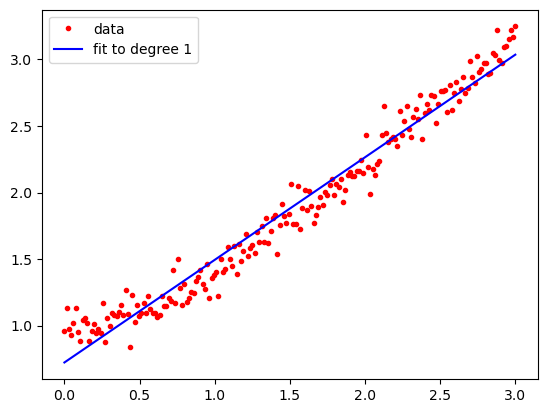

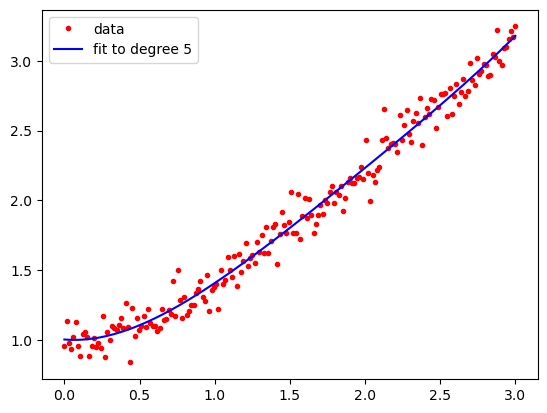

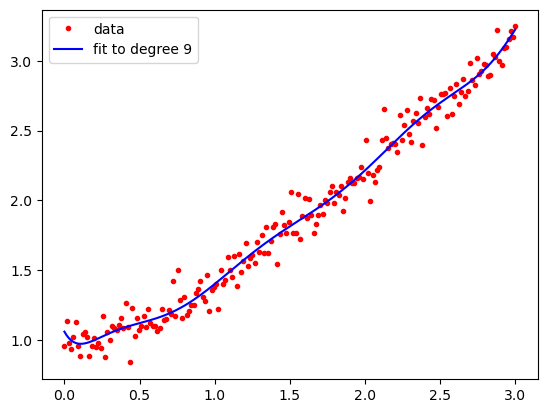

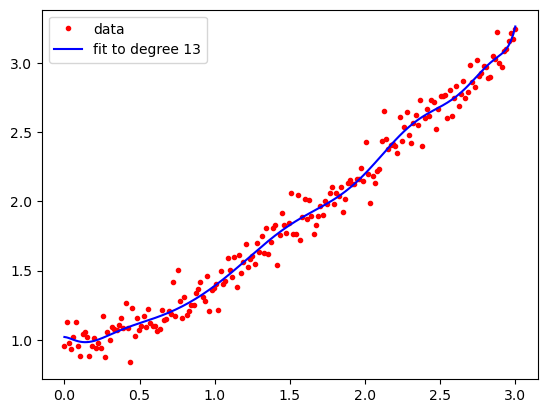

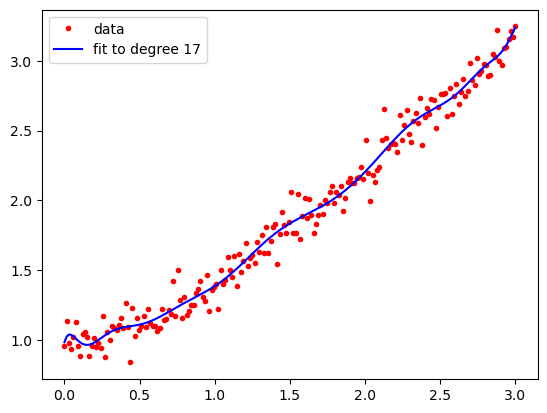

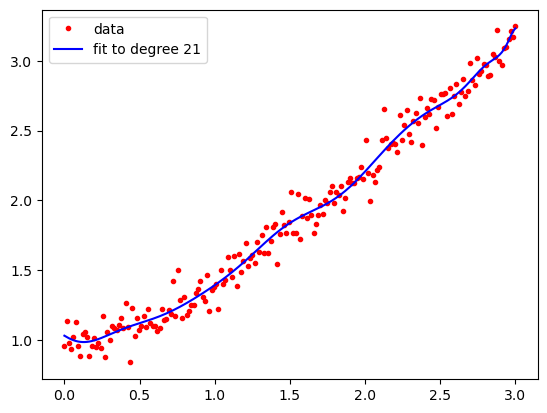

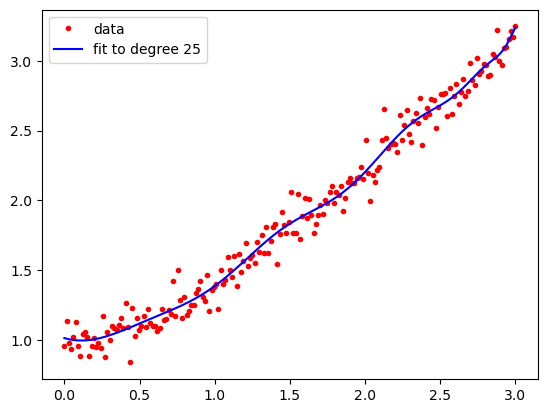

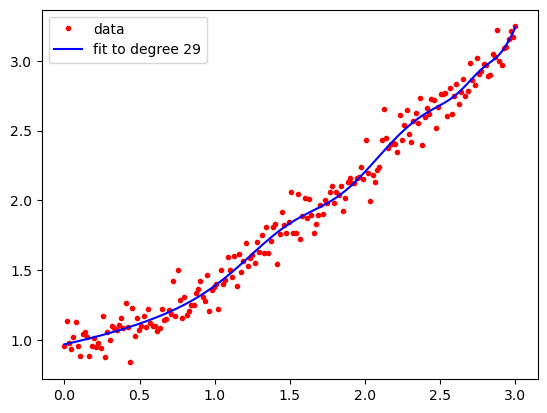

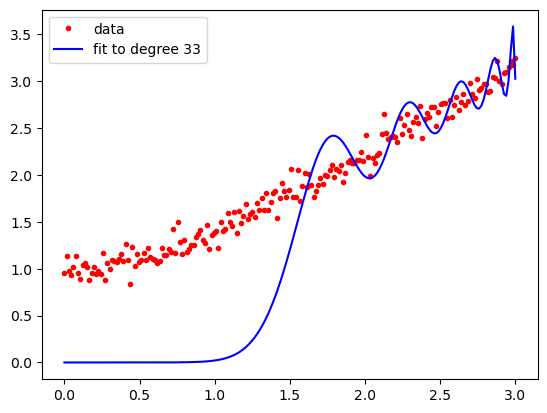

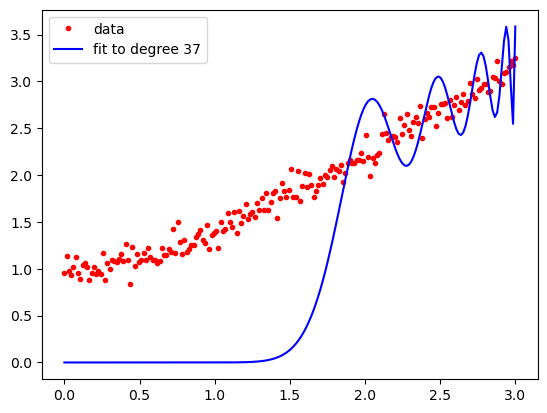

In [4]:
f = figure()
for n in 1:4:40
    display(withfig(f) do
        A = x .^ (0:n)'
        c = A \ yn
        plot(x, yn, "r.")
        plot(x, A * c, "b-")
        legend(["data", "fit to degree $n"], loc="upper left")
    end)
end

One of the things to notice is that, once the degree $n$ goes above 29 or so, the fit goes crazy.  That is because the matrix $A$ is becoming so **ill-conditioned** that roundoff errors are killing us: we are **no longer solving the least-square problem accurately**.

(In practice, one rarely fits to polynomials of such high degree to *noisy* data; the same conditioning problems mean that the fit parameters become increasingly sensitive to errors in the data as you increase the polynomial degree: you are "fitting the noise".)

Let's use `cond(A)` to compute and plot the condition number as a function of the degree $n$:

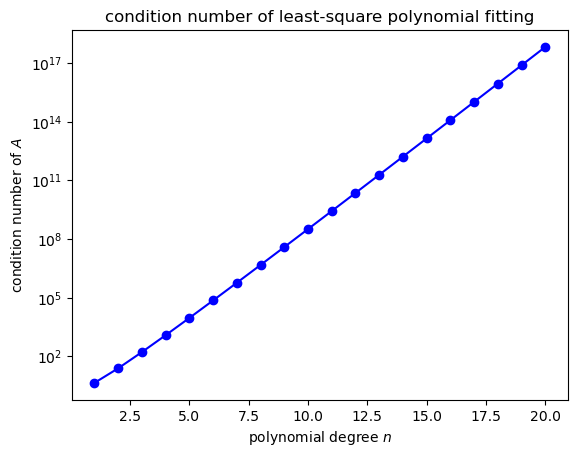

PyObject Text(0.5, 1.0, 'condition number of least-square polynomial fitting')

In [5]:
using LinearAlgebra # for cond and other functions

N = 1:20
semilogy(N, [cond(x .^ (0:n)') for n in N], "bo-")
xlabel(L"polynomial degree $n$")
ylabel(L"condition number of $A$")
title("condition number of least-square polynomial fitting")

As you can see, the condition number increases *exponentially* with $n$.  This is a general problem of with polynomial fits, especially with equispaced $x$ values.

(There are special polynomial-fitting techniques based on [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) which allow high-degree polynomial interpolation without this kind of problem, but they don't use equispaced points.)

# Fitting/Interpolating smooth functions

Fitting *smooth* functions $f(x)$ to high-degree polynomials can be a *very* sensible thing to do, but you have to be careful *how* you do it.

If we sample $m$ points and a degree $m-1$ polynomial, in some sense we aren't really "fitting" anymore.  We have a *square* $m \times m$ matrix system for the coefficients, giving a unique solution: an **interpolating polynomial** (called the [Lagrange interpolating polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial)).   However, we still usually care about how well our interpolating polynomial fits the underlying function $f(x)$ in between the points.

Note, however, that solving an $m \times m$ Vandermonde system is neither the most efficient nor the most accurate (given roundoff errors) method to compute an exact interpolating polynomial.  There is a much better method called [barycentric interpolation](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) that we won't go into here.

## Classic mistake: Equally spaced points

The classic mistake is to fit through *equally spaced points*, which leads to a [Runge phenomenon](https://en.wikipedia.org/wiki/Runge's_phenomenon):

Even if there is *no noise*, fitting *equally spaced points* to high-degree polynomials can lead to disaster if the underlying data is not exactly polynomial.  Let's demonstrate this by fitting the *smooth* function $b(a) = 1/(1+25a^2)$ using interpolating polynomials of degree $n$ through $n+1$ equally-spaced points:

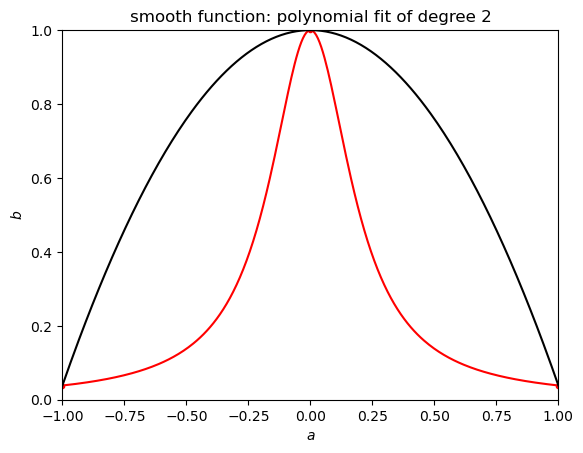

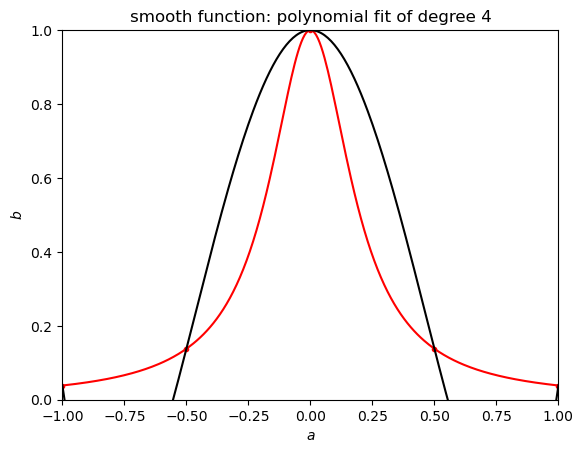

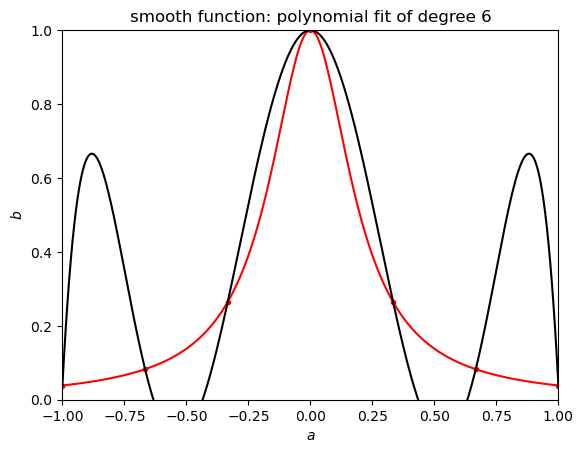

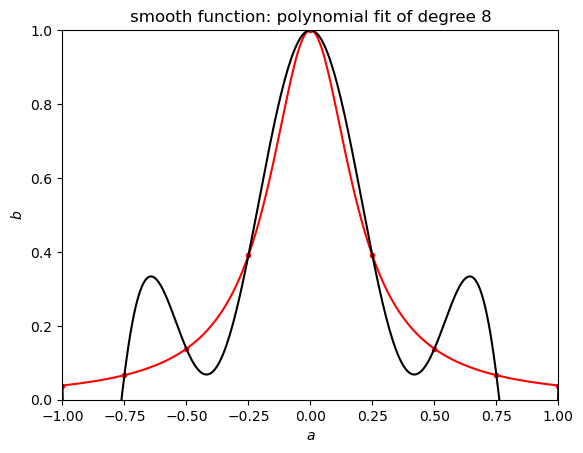

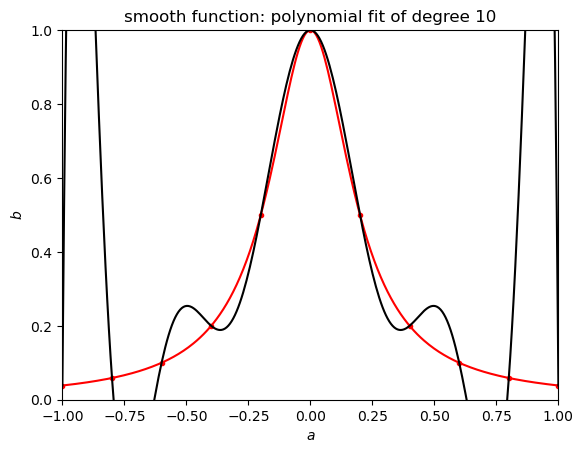

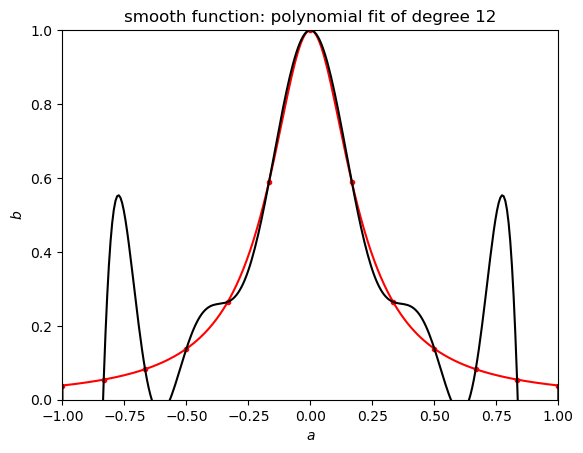

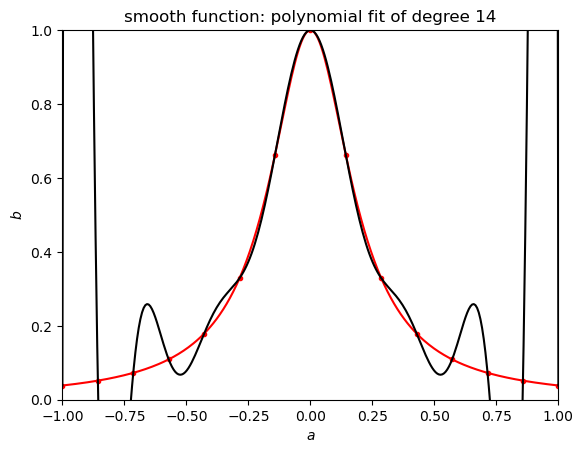

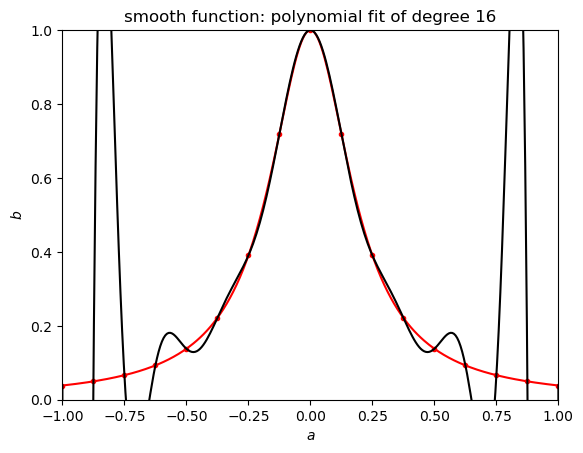

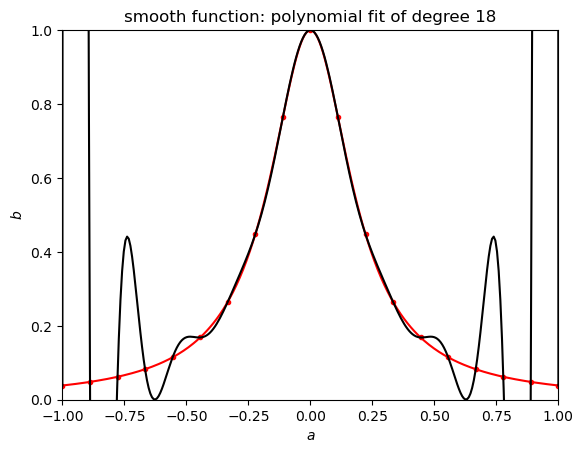

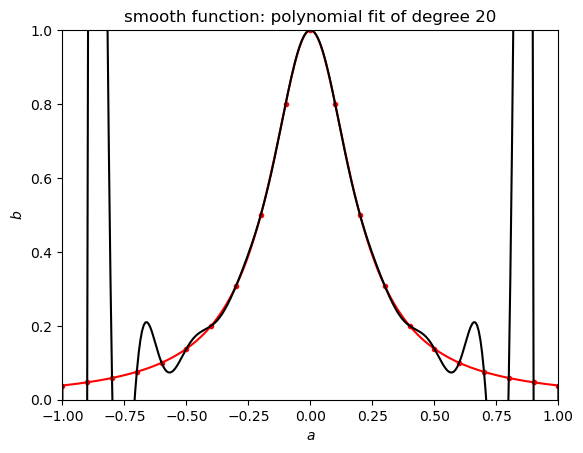

In [6]:
a = range(-1,1,length=50)
afine = range(-1,1,length=300)
bfine = @. 1 / (1 + 25afine^2)
rungefig = figure()
for n=2:2:20
    display(withfig(rungefig) do
        plot(afine, bfine, "r-")
        an = range(-1,1,length=n+1)
        bn = @. 1 / (1 + 25an^2)
        plot(an, bn, "r.")
        A = an .^ (0:n)'
        x̂ = A \ bn
        plot(afine, (afine .^ (0:n)') * x̂, "k-")
        xlabel(L"a")
        ylabel(L"b")
        xlim(-1,1)
        ylim(0,1)
        title("smooth function: polynomial fit of degree $n")
    end)
end

## Chebyshev points

Be careful not to draw the wrong lesson from this.   You have to be *especially careful* when fitting to high-degree polynomials, but this does *not* mean that you should never do it.

In particular, fitting smooth functions to high-degree polynomials can be a *great* thing to do, as **long as you choose the correct points**.  (Separately, as mentioned above, the construction of the interpolating polynomial should technically **not be done by this matrix method** once you go to high degrees — you run into roundoff-error problems — but there are better methods like the barycentric formula.)

For example, here we fit the same $1/(1+25a^2)$ function as above by interpolating a degree-49 polynomial through 50 points, with no Runge problems at all, by choosing the points to be [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes) (which cluster together at the edges of the domain):

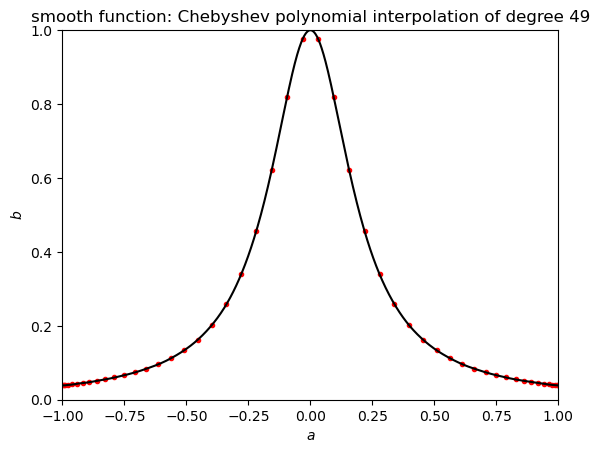

PyObject Text(0.5, 1.0, 'smooth function: Chebyshev polynomial interpolation of degree 49')

In [7]:
n = 50
a = @. cos(((1:n)-0.5) * pi/n) # = Chebyshev nodes of order n
afine = range(-1,1,length=1000)
b = @. 1 ./ (1 + 25a^2)
plot(a, b, "r.")
A = a .^ (0:n-1)'
x̂ = A \ b
plot(afine, (afine .^ (0:n-1)') * x̂, "k-")
xlabel(L"a")
ylabel(L"b")
xlim(-1,1)
ylim(0,1)
title("smooth function: Chebyshev polynomial interpolation of degree $(n-1)")

(The interpolation above will run into numerical troubles if we try to further increase the degree, but that is solely due to roundoff errors incurred because we are finding the interpolant by solving an ill-conditioned $m \times m$ matrix equation.  In practice, as emphasized repeatedly above, there are **much better methods** to construct interpolating polynomials.)